# Functions

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [10]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [11]:
def MIfunc(r, x, dt, window):
    negshift = window[0] # second
    posshift = window[1] # second
    shiftlen = (posshift-negshift)/dt+1
    timeshift = np.linspace(negshift,posshift,int(shiftlen))
    bitshift = np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16') #time-bin-axis of TLPI;
    MIxr = np.zeros(len(bitshift))

    for i in range(len(bitshift)):
        xx=[]
        rr=[]
        shift=bitshift[i] 
        if shift>0:
            xx=x[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            rr=r
        elif shift<0:
            xx=x[:shift]
            rr=r[(-1*shift):]
        xedges = np.append(np.unique(xx),(max(xx)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        N, _, _ = np.histogram2d(xx, rr, bins=(xedges, redges)) 
        px=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis]
        pr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :]
        pxr=N/np.sum(N)

        MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        if shift==0:
            Hr = -np.nansum(pr*np.log2(pr))/dt  
    return timeshift, MIxr, Hr


def MIfunc4ISI(r, x, Spike, dt, window, PorP):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    MIxr = np.zeros(len(bitshift))

    for i in range(len(bitshift)):
        xx=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            rr=r[:(-1*shift)]
            SS=np.hstack((Spike[:sum(rr)+1],Spike[-1]-timeshift[i]))
        elif shift==0:
            xx=x
            rr=r
            SS=Spike
        elif shift<0:
            xx=x[:shift]
            rr=r[(-1*shift):]
            SS=np.hstack((-timeshift[i],Spike[-sum(rr)-1:]))
        if len(SS)-2 != sum(rr):
            print(timeshift[i], SS[0:2], i)
            print(len(SS), sum(rr))
        new_xx = []
        new_vv = []
        post_ISI,_ = EqualState(np.diff(SS)[1:],cut_state_num)
        pre_ISI,_ = EqualState(np.diff(SS)[:-1],cut_state_num)
        for j in np.squeeze(np.where(rr != 0)):
            for k in range(rr[j]):
                new_xx.append(xx[j])
        new_xx = np.array(new_xx)
        if PorP == 'post':
            new_rr = post_ISI
        elif PorP == 'pre':
            new_rr = pre_ISI
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(new_xx),(max(new_xx)+1))
        redges = np.append(np.unique(new_rr),(max(new_rr)+1))
        N, _, _ = np.histogram2d(new_xx, new_rr, bins=(xedges, redges)) 
        px=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis]
        pr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :]
        pxr=N/np.sum(N)

        MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt

        if shift==0:
            Hr = -np.nansum(pr*np.log2(pr))/dt
    return timeshift, MIxr, Hr

# Load and Set

In [12]:
# exp_folder = 'D:\\GoogleDrive\\retina\\Troy\'s data\\20211029\\SplitData\\'
# channelnumber = 51
# filenames = ['diode_OU_tau=500ms_cutoff=1_mean=10_C=0.1_30-Oct-2021_0',
#              'diode_OU_tau=500ms_cutoff=1_mean=10_C=0.2_30-Oct-2021_0',
#              'diode_OU_tau=500ms_cutoff=1_mean=10_C=0.3_30-Oct-2021_0']
# plotLabels = ['C=0.1','C=0.2','C=0.3']

exp_folder = 'D:\\GoogleDrive\\retina\\Troy\'s data\\20210908\\SplitData\\'
channelnumber = 15
filenames = ['diode_OU_tau=500ms_cutoff=1_mean=10_amp=0.5_11-Aug-2021_0',
             'diode_OU_tau=500ms_cutoff=1_mean=10_amp=1_11-Aug-2021_0',
             'diode_OU_tau=500ms_cutoff=1_mean=10_amp=1.5_11-Aug-2021_0',
             'diode_OU_tau=500ms_cutoff=1_mean=10_amp=2_11-Aug-2021_0',
             'diode_OU_tau=500ms_cutoff=1_mean=10_amp=3_11-Aug-2021_0']
plotLabels = ['C=0.05','C=0.1','C=0.15','C=0.2','C=0.3']

In [13]:
dt = 0.01
global cut_state_num
cut_state_num = 8

x_list = []
T_list = []
Spike_list = []
for filename in filenames:
    annots = loadmat(exp_folder+filename, squeeze_me = True)
    sampling_rate = 20000
    TimeStamps = annots['TimeStamps']
    x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
    x = x[::int(sampling_rate*dt)]
    x = x.astype(float)
    x = (x-np.mean(x))/np.std(x)
    T=np.arange(len(x))*dt
    Spike = annots['Spikes'][channelnumber-1]
    Spike = Spike[np.where(Spike>TimeStamps[0])[0][0]:np.where(Spike<TimeStamps[1])[0][-1]]-TimeStamps[0]

    x_list.append(x.copy())
    T_list.append(T.copy())
    Spike_list.append(Spike.copy())
    print(len(Spike))

xstate_list = [EqualState(x, cut_state_num)[0] for x in x_list]

235
363
534
928
1266


# Rate code

In [14]:
rstate_list = [np.histogram(Spike, np.append(T, T[-1]+dt))[0] for Spike in Spike_list]
rateInformation_list = [0]*len(filenames)
rateHr_list = [0]*len(filenames)
for i in range(len(filenames)):
    timeshift, rateInformation_list[i], rateHr_list[i] = MIfunc(rstate_list[i], xstate_list[i], dt, [-1,1])

In [15]:
for i in range(len(filenames)):
    print(np.unique(rstate_list[i]))

[0 1 2]
[0 1 2 3]
[0 1 2 3 4 5]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6 7 9]


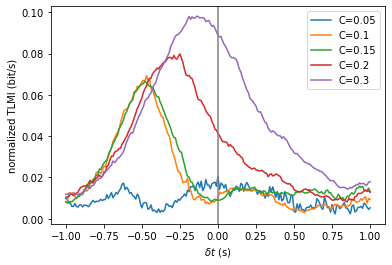

In [16]:
for i in range(len(filenames)):
    plt.plot(timeshift,rateInformation_list[i]/rateHr_list[i] , label=plotLabels[i])
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Rate code ('Binary-Word')

In [17]:
def binaryState(spikeTrain, wordLength, dt, Ttotal):
    rstate,_ = np.histogram(spikeTrain, np.arange(0,Ttotal+1.5*dt,dt/wordLength))
    rstate[rstate>1] = 1
    rstate = rstate[:wordLength*int(len(rstate)/wordLength)]
    _, index = np.unique(rstate.reshape((-1,wordLength)), axis = 0, return_inverse=True)
    return index

In [18]:
wordLength = 3

wordstate_list = [0]*len(filenames)
wordInformation_list = [0]*len(filenames)
wordHr_list = [0]*len(filenames)
for i in range(len(filenames)):
    wordstate_list[i] = binaryState(Spike_list[i], wordLength, dt, T[-1])
    timeshift, wordInformation_list[i], wordHr_list[i] = MIfunc(wordstate_list[i], xstate_list[i], dt, [-1,1])

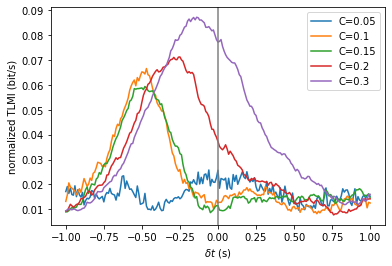

In [19]:
for i in range(len(filenames)):
    plt.plot(timeshift,wordInformation_list[i]/wordHr_list[i] , label=plotLabels[i])
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Time code (event = bin)

In [20]:
timestate_list = [0]*len(filenames)
timeInformation_list = [0]*len(filenames)
timeHr_list = [0]*len(filenames)
for i in range(len(filenames)):
    HeadSpikeEnd = np.hstack((0, Spike_list[i], T_list[i][-1]+dt))
    ISI = np.zeros(len(rstate_list[i]))

    counter = 0
    for j in range(len(rstate_list[i])):
        counter += rstate_list[i][j]
        ISI[j] = (HeadSpikeEnd[counter+1]-HeadSpikeEnd[counter-rstate_list[i][j]])/(rstate_list[i][j]+1)
        
    timestate_list[i], _ = EqualState(ISI, cut_state_num)

    timeshift, timeInformation_list[i], timeHr_list[i] = MIfunc(timestate_list[i], xstate_list[i], dt, [-1,1])

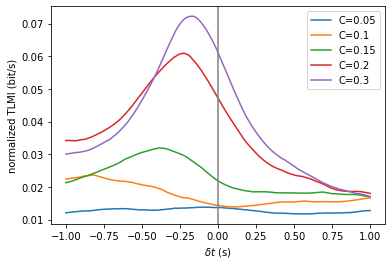

In [21]:
for i in range(len(filenames)):
    plt.plot(timeshift,timeInformation_list[i]/timeHr_list[i] , label=plotLabels[i])
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Time code (event = spike; pre-ISI)

In [22]:
preInformation_list = [0]*len(filenames)
preHr_list = [0]*len(filenames)
for i in range(len(filenames)):
    HeadSpikeEnd = np.hstack((0, Spike_list[i], T_list[i][-1]+dt))
    timeshift, preInformation_list[i], preHr_list[i] = MIfunc4ISI(rstate_list[i], xstate_list[i], HeadSpikeEnd, dt, [-1,1], 'pre')

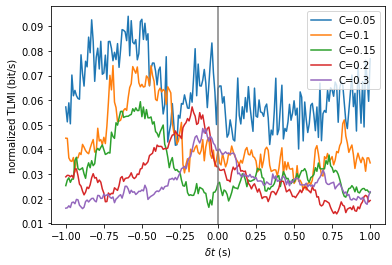

In [23]:
for i in range(len(filenames)):
    plt.plot(timeshift,preInformation_list[i]/preHr_list[i] , label=plotLabels[i])
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Time code (event = spike; post-ISI)

In [24]:
postInformation_list = [0]*len(filenames)
postHr_list = [0]*len(filenames)
for i in range(len(filenames)):
    HeadSpikeEnd = np.hstack((0, Spike_list[i], T_list[i][-1]+dt))
    timeshift, postInformation_list[i], postHr_list[i] = MIfunc4ISI(rstate_list[i], xstate_list[i], HeadSpikeEnd, dt, [-1,1], 'post')

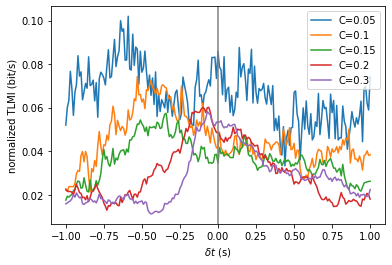

In [25]:
for i in range(len(filenames)):
    plt.plot(timeshift,postInformation_list[i]/postHr_list[i] , label=plotLabels[i])
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Comparasion

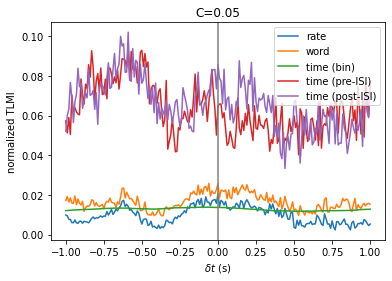

In [26]:
i = 0

plt.plot(timeshift, rateInformation_list[i]/rateHr_list[i], label='rate')
plt.plot(timeshift, wordInformation_list[i]/wordHr_list[i], label='word')
plt.plot(timeshift, timeInformation_list[i]/timeHr_list[i], label='time (bin)')
plt.plot(timeshift, preInformation_list[i]/preHr_list[i]  , label='time (pre-ISI)')
plt.plot(timeshift, postInformation_list[i]/postHr_list[i], label='time (post-ISI)')
plt.title(plotLabels[i])
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

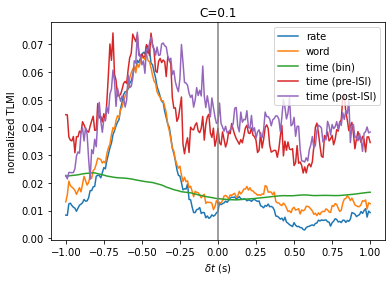

In [27]:
i = 1

plt.plot(timeshift, rateInformation_list[i]/rateHr_list[i], label='rate')
plt.plot(timeshift, wordInformation_list[i]/wordHr_list[i], label='word')
plt.plot(timeshift, timeInformation_list[i]/timeHr_list[i], label='time (bin)')
plt.plot(timeshift, preInformation_list[i]/preHr_list[i]  , label='time (pre-ISI)')
plt.plot(timeshift, postInformation_list[i]/postHr_list[i], label='time (post-ISI)')
plt.title(plotLabels[i])
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

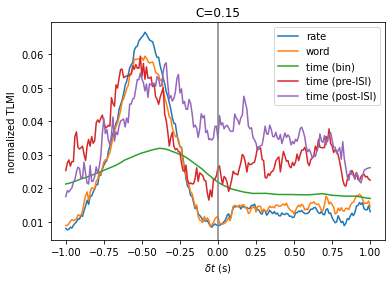

In [28]:
i = 2

plt.plot(timeshift, rateInformation_list[i]/rateHr_list[i], label='rate')
plt.plot(timeshift, wordInformation_list[i]/wordHr_list[i], label='word')
plt.plot(timeshift, timeInformation_list[i]/timeHr_list[i], label='time (bin)')
plt.plot(timeshift, preInformation_list[i]/preHr_list[i]  , label='time (pre-ISI)')
plt.plot(timeshift, postInformation_list[i]/postHr_list[i], label='time (post-ISI)')
plt.title(plotLabels[i])
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

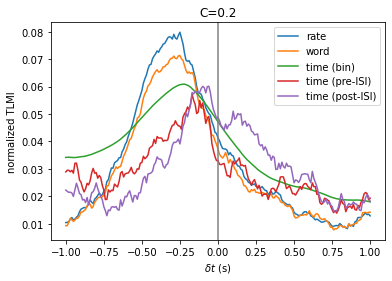

In [29]:
i = 3

plt.plot(timeshift, rateInformation_list[i]/rateHr_list[i], label='rate')
plt.plot(timeshift, wordInformation_list[i]/wordHr_list[i], label='word')
plt.plot(timeshift, timeInformation_list[i]/timeHr_list[i], label='time (bin)')
plt.plot(timeshift, preInformation_list[i]/preHr_list[i]  , label='time (pre-ISI)')
plt.plot(timeshift, postInformation_list[i]/postHr_list[i], label='time (post-ISI)')
plt.title(plotLabels[i])
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

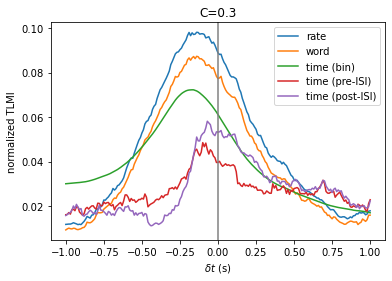

In [30]:
i = 4

plt.plot(timeshift, rateInformation_list[i]/rateHr_list[i], label='rate')
plt.plot(timeshift, wordInformation_list[i]/wordHr_list[i], label='word')
plt.plot(timeshift, timeInformation_list[i]/timeHr_list[i], label='time (bin)')
plt.plot(timeshift, preInformation_list[i]/preHr_list[i]  , label='time (pre-ISI)')
plt.plot(timeshift, postInformation_list[i]/postHr_list[i], label='time (post-ISI)')
plt.title(plotLabels[i])
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')